In [40]:
import pandas as pd
import numpy as np
import os
import ants
from tqdm import tqdm
from matplotlib import pyplot as plt

In [41]:
df = pd.read_csv('../Data/ABIDE_legend_S982.csv')
df

,Unnamed: 0,index,BIDS_ID,Anonymized ID,Subject Type,Visit,Days since enrollment,SubID,DxGroup,DSMIVTR,...,WISC4 Sym Scaled,Age at MPRAGE,Current Med Status,Medication Name,Medication Name.1,Off stimulants at EPI scan?,ScanSite,ScannerType,ScannerID,ScanSiteID
0,0,0,sub-001,A00033348,PATIENT,session_1,8,51320,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
1,1,1,sub-002,A00033398,CONTROL,session_1,8,51373,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
2,2,2,sub-003,A00033352,PATIENT,session_1,8,51324,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
3,3,3,sub-004,A00033389,CONTROL,session_1,8,51364,2,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
4,4,4,sub-005,A00033354,PATIENT,session_1,8,51326,1,2.0,...,NaN,NaN,0.0,NaN,NaN,NaN,mpg,verio,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977,977,1094,sub-985,A00032725,CONTROL,session_1,28,51252,2,0.0,...,NaN,10.99,0.0,NaN,NaN,NaN,ucla,triotim,6,12
978,978,1095,sub-986,A00032704,PATIENT,session_1,28,51229,1,1.0,...,NaN,14.59,0.0,NaN,NaN,NaN,ucla,triotim,6,12
979,979,1096,sub-987,A00032740,CONTROL,session_1,28,51268,2,0.0,...,NaN,17.78,0.0,NaN,NaN,NaN,ucla,triotim,6,12
980,980,1098,sub-989,A00032686,PATIENT,session_1,28,51210,1,1.0,...,NaN,16.56,0.0,NaN,NaN,NaN,ucla,triotim,6,12


In [42]:
indir = '../../data/fMRI_InData/abide_bids/'

In [43]:
asubs = [sub for sub in os.listdir(indir) if sub.startswith('sub-')]
asubs.sort()
len(asubs)

1109

In [44]:
df['BIDS_ID'].isin(asubs).values.mean()

1.0

In [45]:
all_bad_subs = np.array(asubs)[np.array([sub not in df['BIDS_ID'].values for sub in asubs])]
bad_subs = all_bad_subs
has_anat = np.array([os.path.exists(os.path.join(indir,sub,'anat',f'{sub}_T1w.nii')) for sub in bad_subs])
f'{(~has_anat).sum()} dont have anat'
bad_subs = bad_subs[has_anat]

In [46]:
has_anat.sum()

117

In [47]:
has_segment = np.array([os.path.exists(os.path.join(indir,sub,'anat',f'c1{sub}_T1wo.nii')) for sub in bad_subs])
has_segment.sum()

109

In [48]:
has_brain = np.array([os.path.exists(os.path.join(indir,sub,'anat',f'{sub}_brain.nii')) for sub in bad_subs])
has_segment.sum()

109

In [49]:
bad_subs

array(['sub-084', 'sub-085', 'sub-086', 'sub-088', 'sub-091', 'sub-093',
       'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099',
       'sub-101', 'sub-102', 'sub-104', 'sub-105', 'sub-106', 'sub-108',
       'sub-109', 'sub-110', 'sub-111', 'sub-112', 'sub-113', 'sub-117',
       'sub-119', 'sub-121', 'sub-122', 'sub-123', 'sub-124', 'sub-125',
       'sub-126', 'sub-127', 'sub-128', 'sub-129', 'sub-130', 'sub-132',
       'sub-133', 'sub-134', 'sub-135', 'sub-136', 'sub-137', 'sub-138',
       'sub-140', 'sub-141', 'sub-142', 'sub-143', 'sub-144', 'sub-145',
       'sub-146', 'sub-149', 'sub-150', 'sub-151', 'sub-152', 'sub-153',
       'sub-154', 'sub-155', 'sub-156', 'sub-158', 'sub-159', 'sub-160',
       'sub-161', 'sub-162', 'sub-163', 'sub-164', 'sub-165', 'sub-166',
       'sub-167', 'sub-168', 'sub-169', 'sub-172', 'sub-175', 'sub-176',
       'sub-178', 'sub-179', 'sub-180', 'sub-181', 'sub-182', 'sub-183',
       'sub-184', 'sub-185', 'sub-186', 'sub-187', 

In [50]:
def snr(t1):
    return t1.numpy().mean() / t1.numpy().std()

(array([ 7.,  6., 17., 27., 19., 15., 12.,  5.,  5.,  4.]),
 array([0.43395758, 0.45061916, 0.46728075, 0.48394233, 0.5006039 ,
        0.5172655 , 0.5339271 , 0.55058867, 0.56725025, 0.58391184,
        0.6005734 ], dtype=float32),
 <BarContainer object of 10 artists>)

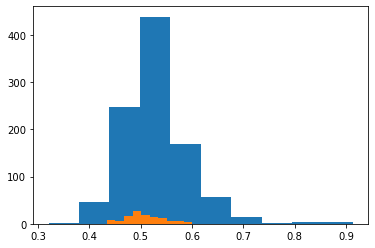

In [51]:
snr_badsubs = np.load('../Data/snr_badsubs.npy')
snr_goodsubs = np.load('../Data/snr_goodsubs.npy')

plt.hist(snr_goodsubs)
plt.hist(snr_badsubs)

In [52]:
import scipy 
scipy.stats.ttest_ind(snr_goodsubs,snr_badsubs)

Ttest_indResult(statistic=3.6656546709291766, pvalue=0.0002585168811724025)

In [95]:
qc = pd.read_csv('~/qc_reports/group_T1w.tsv',delimiter='\t')
qc['subID'] = qc['bids_name'].apply(lambda x: x.replace('_T1w',''))
print(qc.shape)
qc.head()

(1004, 70)


,bids_name,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,...,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,subID
0,sub-001_T1w,0.504362,2.591807,0.781646,81.625397,3.188993,3.11268,3.59866,2.85564,0.203270,...,999.997314,252408.0,886.195633,1121.342273,72.227188,0.177965,0.412156,0.504863,0.600998,sub-001
1,sub-002_T1w,0.619077,1.996973,0.795587,41.743824,3.217867,3.13355,3.65594,2.86411,0.189991,...,1000.024048,276108.0,872.820822,1145.791266,84.272400,0.181564,0.437266,0.513251,0.501716,sub-002
2,sub-003_T1w,0.603486,2.125920,0.767166,41.010826,3.072290,3.01157,3.39061,2.81469,0.222876,...,1000.017456,177226.0,874.910004,1136.792908,79.685738,0.144619,0.412080,0.495313,0.458649,sub-003
3,sub-004_T1w,0.462630,2.866749,0.751816,81.259102,3.455247,3.32218,3.81503,3.22853,0.206551,...,1000.036011,222304.0,888.049173,1109.860724,67.727448,0.183967,0.455735,0.507421,0.503763,sub-004
4,sub-005_T1w,0.610489,2.115841,0.778560,57.203358,3.160873,3.11590,3.50819,2.85853,0.212498,...,1000.022705,234284.0,882.268057,1131.794220,76.850983,0.169941,0.418061,0.494876,0.544170,sub-005


In [96]:
good_subs_idx = qc['subID'].isin(df['BIDS_ID']).values
bad_subs_idx = qc['subID'].isin(bad_subs).values

In [97]:
good_subs.sum()

887

In [98]:
bad_subs_idx.sum()

117

CPU times: user 1.8 s, sys: 991 µs, total: 1.8 s
Wall time: 1.81 s


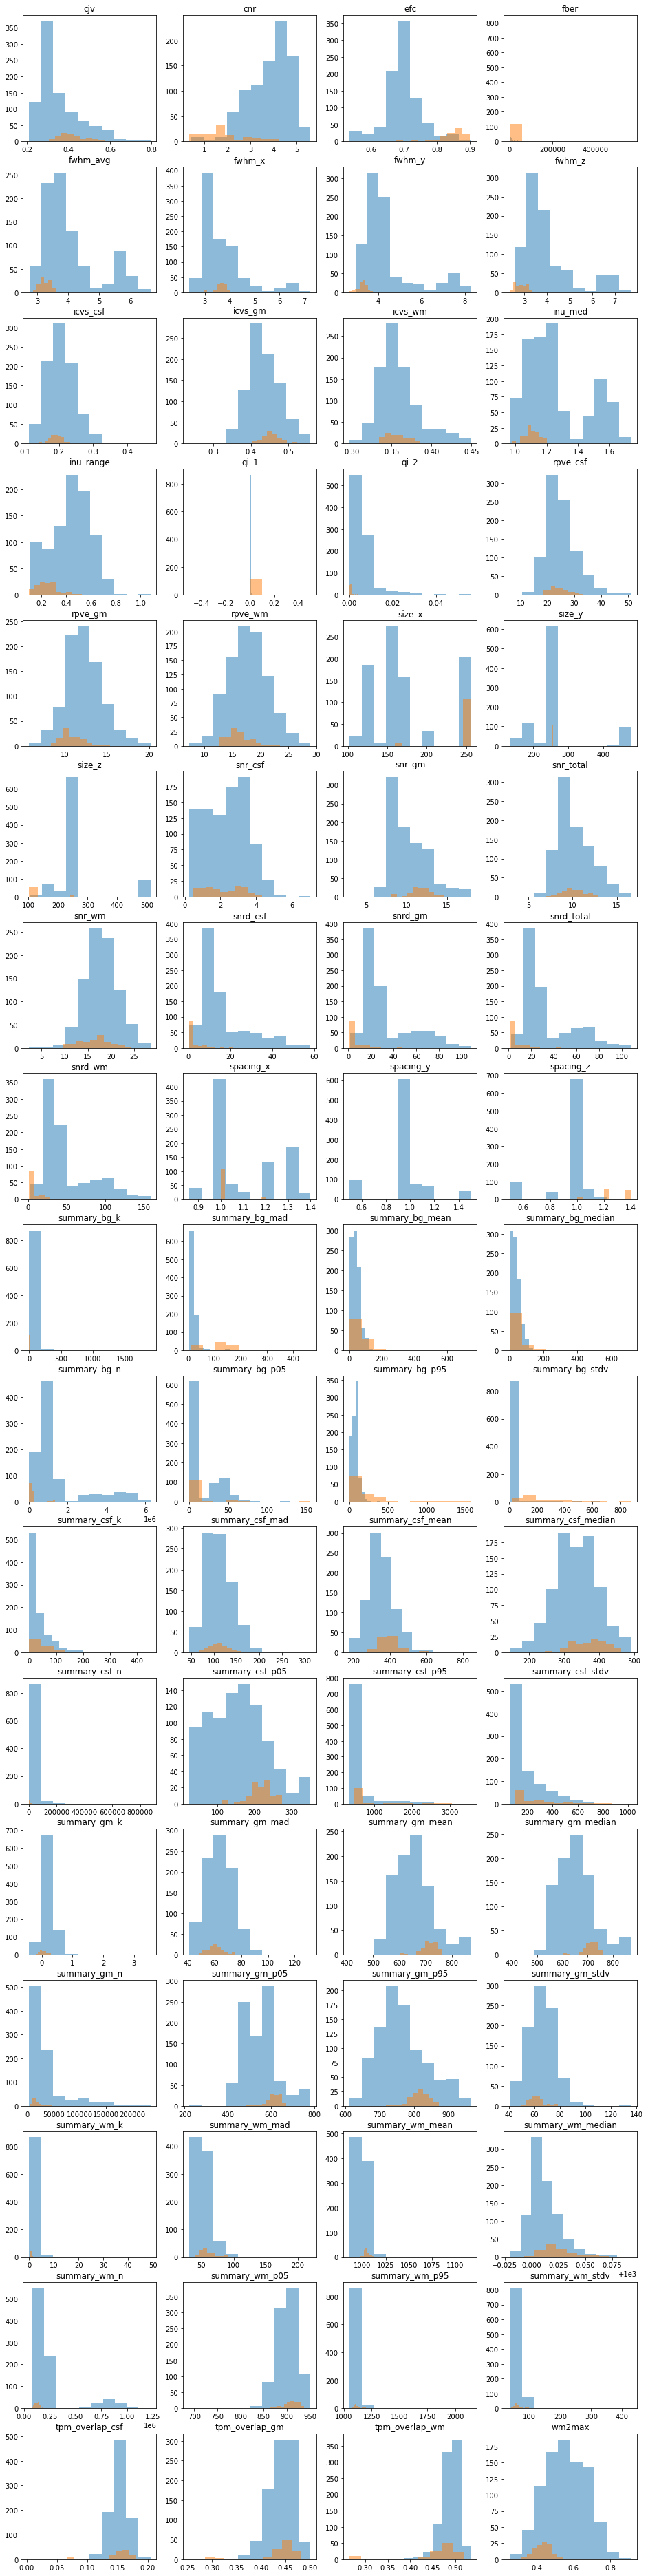

In [178]:
%%time
keys = qc.columns[1:-2]
plt.subplots(17,4,figsize=np.array((4,17))*4);
for i in range(len(keys)):
    plt.subplot(17,4,i+1)
    plt.hist(qc[keys[i]].values[good_subs_idx],alpha=.5)
    plt.hist(qc[keys[i]].values[bad_subs_idx],alpha=.5)
    #sns.distplot(qc[keys[i]].values[good_subs_idx])
    #sns.distplot(qc[keys[i]].values[bad_subs_idx])
    plt.title(keys[i])
    #plt.show()

In [136]:
qc_badsubs = qc.iloc[bad_subs_idx]
qc_badsubs.head()

,bids_name,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,...,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,subID,summary_bg_t
83,sub-084_T1w,0.555572,0.650194,0.801718,1900.738525,3.071470,3.661060,2.946330,2.607021,0.197927,...,104951.0,884.416718,1186.971069,95.181969,0.072366,0.294576,0.280975,0.329995,sub-084,0.718603
84,sub-085_T1w,0.374650,1.558655,0.871727,40.144958,3.481841,3.817481,3.548985,3.079058,0.204017,...,149631.0,927.625732,1092.765442,50.473679,0.153440,0.418492,0.426532,0.461520,sub-085,0.000000
85,sub-086_T1w,0.557980,0.494136,0.875247,80.515282,2.925634,3.592940,2.749720,2.434243,0.180159,...,96971.0,893.010345,1162.622864,84.060074,0.072982,0.295089,0.265256,0.424555,sub-086,0.691218
87,sub-088_T1w,0.364738,0.940453,0.847111,34.644058,3.204434,3.681760,3.299150,2.632393,0.175635,...,134873.0,914.449707,1103.708716,58.182503,0.171177,0.446011,0.477649,0.395950,sub-088,0.000000
90,sub-091_T1w,0.529109,1.344169,0.844189,87.802010,3.024998,3.721210,2.820860,2.532925,0.165593,...,94421.0,870.479370,1170.833252,91.642082,0.071321,0.308166,0.273655,0.317648,sub-091,0.729679


CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 895 ms


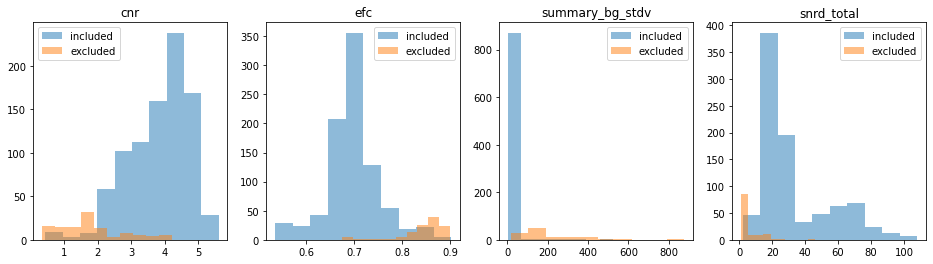

In [239]:
%%time
keys = ['cnr','efc','summary_bg_stdv','snrd_total']
plt.subplots(1,4,figsize=np.array((4,1))*4);
for i in range(len(keys)):
    plt.subplot(1,4,i+1)
    plt.hist(qc[keys[i]].values[good_subs_idx],alpha=.5)
    plt.hist(qc[keys[i]].values[bad_subs_idx],alpha=.5)
    plt.title(keys[i])
    plt.legend(['included','excluded'])

In [180]:
v1 = (qc_badsubs['cnr'] < 2).values;v1.sum()

82

In [181]:
v2 = (qc_badsubs['efc'] > .8 ).values;v2.sum()

105

In [182]:
v3 = (qc_badsubs['summary_bg_stdv'] > 50 ).values;v3.sum()

97

In [183]:
v3 = (qc_badsubs['snrd_total'] < 5 ).values;v3.sum()

85

In [188]:
(v1+v2+v3)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False])

In [224]:
qc_table = qc_badsubs.copy()
#qc_table = qc.copy()
qc_table = qc_table[['bids_name','cnr','efc','summary_bg_stdv','snrd_total']]
qc_table['cnr < 2'] = qc_table['cnr'] < 2
qc_table['efc > .8'] = qc_table['efc'] > .8
qc_table['snrd < 5'] = qc_table['snrd_total'] < 5
qc_table['bg_stdev > 50'] = qc_table['summary_bg_stdv'] > 50
qc_table.reset_index(inplace=True)

In [228]:
qc_table.head(25)

,index,bids_name,cnr,efc,summary_bg_stdv,snrd_total,cnr < 2,efc > .8,snrd < 5,bg_stdev > 50
0,83,sub-084_T1w,0.650194,0.801718,401.412872,2.039182,True,True,True,True
1,84,sub-085_T1w,1.558655,0.871727,160.054384,4.062470,True,True,True,True
2,85,sub-086_T1w,0.494136,0.875247,511.113892,3.157996,True,True,True,True
3,87,sub-088_T1w,0.940453,0.847111,330.819917,3.656234,True,True,True,True
4,90,sub-091_T1w,1.344169,0.844189,181.752060,3.526720,True,True,True,True
5,92,sub-093_T1w,1.172038,0.826015,249.177887,46.082072,True,True,False,True
6,93,sub-094_T1w,0.835836,0.864368,288.926025,3.441923,True,True,True,True
7,94,sub-095_T1w,1.756638,0.784118,134.055054,9.921466,True,False,False,True
8,95,sub-096_T1w,1.741503,0.854279,110.474144,2.745579,True,True,True,True
9,96,sub-097_T1w,1.777531,0.874293,131.757224,3.563461,True,True,True,True


In [236]:
#qc_table.groupby(by='index',level=0).sum()
qc_table[['cnr < 2', 'efc > .8', 'snrd < 5', 'bg_stdev > 50']].sum(axis=0)

cnr < 2           82
efc > .8         105
snrd < 5          85
bg_stdev > 50     97
dtype: int64

In [235]:
qc_table.columns

Index(['index', 'bids_name', 'cnr', 'efc', 'summary_bg_stdv', 'snrd_total',
       'cnr < 2', 'efc > .8', 'snrd < 5', 'bg_stdev > 50'],
      dtype='object')

In [152]:
#qc['fber'].values[good_subs_idx].max()

38689.41796875

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/data/aglinska/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

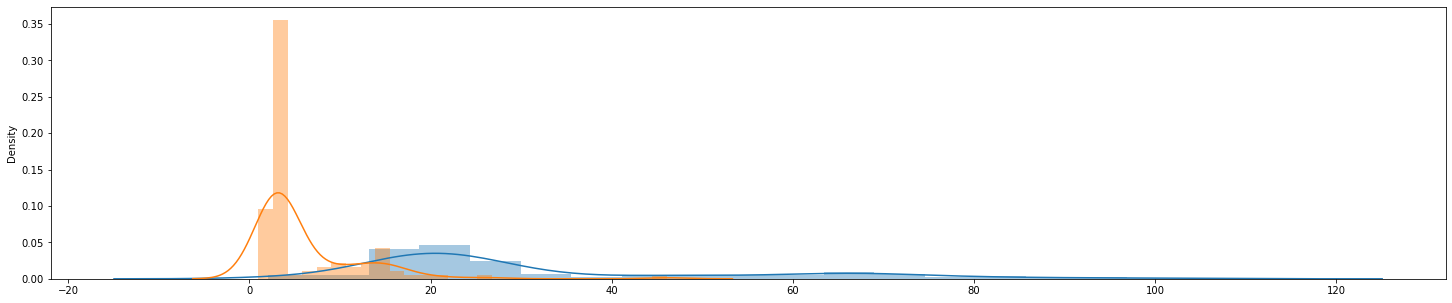

In [172]:
import seaborn as sns
plt.figure(figsize=(25,5))
sns.distplot(qc['snrd_total'].values[good_subs_idx])
sns.distplot(qc['snrd_total'].values[bad_subs_idx])

In [168]:
sns.distplot

<function seaborn.distributions.distplot(a=None, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None, x=None)>

In [133]:
# qc_z = qc.copy()
# for key in keys:
#     qc_z[key] = scipy.stats.zscore(qc_z[key])
    
# qcz_badsubs = qc_z.iloc[bad_subs_idx]

In [134]:
# qc_z.iloc[bad_subs_idx]

In [106]:
qc_z.to_csv('../Data/qc_z.csv')
qc_badsubs.to_csv('../Data/qc_badsubs.csv')

In [110]:
qc_z

,bids_name,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,...,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max,subID
0,sub-001_T1w,1.479212,-0.892744,0.936188,-0.116848,-0.876144,-0.663538,-0.565676,-0.904776,-0.048520,...,-1.041614,0.108897,-0.699165,0.628629,0.771110,1.454152,-1.019049,0.704061,0.512051,sub-001
1,sub-002_T1w,2.651737,-1.423363,1.130589,-0.119026,-0.842148,-0.638402,-0.517498,-0.897180,-0.389396,...,0.665242,0.225561,-1.318430,1.196486,1.472745,1.663471,-0.138651,0.991233,-0.363283,sub-002
2,sub-003_T1w,2.492374,-1.308337,0.734261,-0.119066,-1.013552,-0.785311,-0.740667,-0.941500,0.454806,...,0.244373,-0.261191,-1.221699,0.987488,1.205571,-0.485348,-1.021712,0.377137,-0.742995,sub-003
3,sub-004_T1w,1.052663,-0.647483,0.520207,-0.116868,-0.562654,-0.411223,-0.383688,-0.570367,0.035698,...,1.429041,-0.039292,-0.613344,0.361956,0.508999,1.803283,0.508894,0.791638,-0.345237,sub-004
4,sub-005_T1w,2.563960,-1.317328,0.893148,-0.118182,-0.909253,-0.659660,-0.641770,-0.902184,0.188386,...,0.579509,0.019680,-0.881015,0.871388,1.040446,0.987472,-0.812029,0.362186,0.011018,sub-005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,sub-995_T1w,-0.550608,0.547855,-0.288817,-0.118907,-0.894906,-0.758990,-0.786961,-0.640632,-0.374838,...,-1.326090,-0.273478,-0.028591,-0.180655,-0.137032,0.038650,0.821525,0.360041,-0.818099,sub-995
1000,sub-996_T1w,-0.417992,0.405409,-0.259353,-0.119211,-0.957667,-0.861652,-0.783109,-0.711703,-0.918526,...,-0.297300,-0.499064,-0.128734,-0.080272,-0.023592,1.540988,1.158895,0.653432,-0.745290,sub-996
1001,sub-997_T1w,0.375343,-0.311770,0.559002,-0.119235,-0.932987,-0.800972,-0.807425,-0.674567,0.544054,...,0.552231,-0.272478,0.353160,0.025468,-0.126332,-0.540051,-0.641501,0.255783,-0.179498,sub-997
1002,sub-998_T1w,-0.290961,0.314572,-0.544545,-0.119119,-0.855347,-0.711146,-0.758456,-0.616257,-0.529142,...,0.684727,-0.484385,0.060688,-0.015287,-0.023426,0.005181,0.540571,-0.121910,-1.152419,sub-998


In [129]:
# qc['summary_bg_t'] = qc['summary_bg_mean']/qc['summary_bg_stdv']
# plt.hist(qc['summary_bg_t'].values[good_subs_idx],alpha=.5)
# plt.hist(qc['summary_bg_t'].values[bad_subs_idx],alpha=.5)